# Toy convex high condition number exp

In [500]:
import torch
import numpy as np

# create a problem with controlled condition number
kappa = 10**4 # condition number to vary

d = 50 # feature dimension, keep this <= n so that condition number is finite
n = 300 # number of observations

x_star = np.random.randn(d)
x_star = x_star / np.linalg.norm(x_star)

noise = np.random.randn(n)
noise = noise / np.linalg.norm(noise) * 1e-3

# data matrix
A = 1/np.sqrt(n) * np.random.randn(n, d)
U, S, Vh = np.linalg.svd(A) # np.allclose(U[:,:len(S)].dot(np.diag(S)).dot(Vh), A) gives True

# change the eigenvalues
log_smin = -1 # that is mu = 0.1**2
log_smax = np.log10(np.sqrt(kappa) * 10**log_smin) 
S = np.logspace(log_smin, log_smax, d)[::-1]

A = U[:,:len(S)].dot(np.diag(S)).dot(Vh)
y = A.dot(x_star) + noise

''' verify kappa
import matplotlib.pyplot as plt
_,S_,_ = np.linalg.svd(A.T.dot(A))
print(np.max(S_), np.min(S_))
'''

mu = (10**log_smin)**2
L = kappa * mu
print(r'\mu={:.2f}, L={:.2f}, \kappa={:.2f}'.format(mu, L, L/mu))
# this is not axis aligned

\mu=0.01, L=100.00, \kappa=10000.00


In [507]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import tqdm
from lib.optimizer import Diff, Avrng, AdamVR, MomentumCurvature, NormalizedCurvature, Sign, MomentumCurvature2

def train(net, loader, full_loader, optimizer, niters=800, ntrack=10): 
    errors = []
    tracked_params = [[] for _ in range(ntrack)]
    tracked_momentum = [[] for _ in range(ntrack)]
    p = list(net.parameters())[0].cpu().detach().numpy().ravel()
    indices = np.random.choice(range(len(p)), ntrack, replace=False)
    
    for _ in tqdm.tqdm(range(niters)):
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            def closure():
                optimizer.zero_grad()
                o = net(x)
                l = nn.MSELoss()(o.view(-1), y)
                l.backward()
                return l
            optimizer.step(closure)
            
            for x, y in full_loader:
                x, y = x.cuda(), y.cuda()
                o = net(x)
                l = nn.MSELoss()(o.view(-1), y)
                errors.append(l.item())

            p = list(net.parameters())[0].cpu().detach().numpy().ravel()
            for group in optimizer.param_groups:
                for param in group['params']:
                    state = optimizer.state[param]
                    if 'exp_avg' in state:
                        m = state['exp_avg'].cpu().detach().numpy().ravel()
                    else:
                        m = param.grad.data.cpu().detach().numpy().ravel()
                    break
                break
                
            for i, index in enumerate(indices):
                tracked_params[i].append(p[index])
                tracked_momentum[i].append(m[index])
            #errors.append(np.linalg.norm(p - x_star))

    return errors, tracked_params, tracked_momentum

errors = {}
tracked_params = {}
tracked_momentum = {}
lr = 0.001 # 1 / L / 100 #* 10000 #/ 100 # 2/(L+mu)
batch_size = 150
print('lr={:.5f}'.format(lr))
data = TensorDataset(torch.from_numpy(A).float(), torch.from_numpy(y).float())
loader = DataLoader(data, batch_size=batch_size)
full_loader = DataLoader(data, batch_size=n)

for opt in ['MomentumCurvature2', 'MomentumCurvature']: #, 'torch.optim.Adam']: 
    #['MomentumCurvature', 'torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.Adagrad']:
    print(opt)    
    net = nn.Linear(d, 1, bias=False)
    net.cuda()
    net.weight.data = torch.zeros_like(net.weight.data) # zero initialize
    if opt == 'MomentumCurvature':
        optimizer = eval(opt)(net.parameters(), lr=lr)
    if opt == 'MomentumCurvature2':
        optimizer = eval(opt)(net.parameters(), lr=lr)
    elif opt == 'torch.optim.SGD':
        optimizer = eval(opt)(net.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = eval(opt)(net.parameters(), lr=lr)
    name = opt.split('.')[-1]
    errors[name], tracked_params[name], tracked_momentum[name] = train(net, loader, full_loader, optimizer)

  1%|          | 9/800 [00:00<00:09, 82.07it/s]

lr=0.00100
MomentumCurvature2


  1%|▏         | 10/800 [00:00<00:08, 92.98it/s]

MomentumCurvature


100%|██████████| 800/800 [00:11<00:00, 66.95it/s]


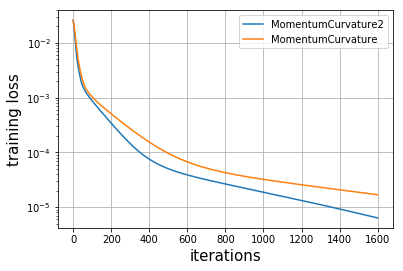

In [508]:
from lib.utils import smooth
import matplotlib.pyplot as plt
for k, e in errors.items():
    plt.semilogy(smooth(e,1), label=k)
    
#plt.ylabel(r'$\Vert x-x^* \Vert_2$', fontsize=15)
plt.ylabel(r'training loss', fontsize=15)
plt.legend()
plt.xlabel('iterations', fontsize=15)
plt.grid()
#plt.ylim([0,1])
plt.show()

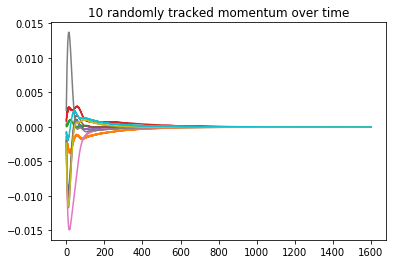

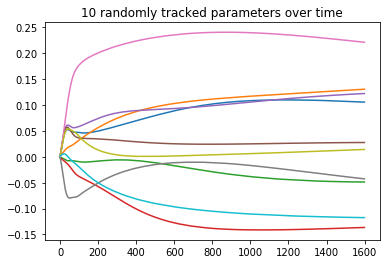

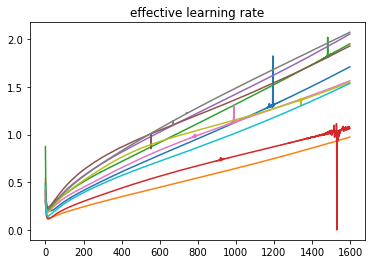

In [509]:
name = 'MomentumCurvature'
for i in range(10):
    m = np.array(tracked_momentum[name][i])
    plt.plot(m)
plt.title('10 randomly tracked momentum over time')
plt.show()

for i in range(10):
    p = np.array(tracked_params[name][i])
    plt.plot(p)
plt.title('10 randomly tracked parameters over time')
plt.show()

for i in range(10):
    p = np.array(tracked_params[name][i])
    diff = p[1:] - p[:-1]
    m = np.array(tracked_momentum[name][i])[1:] # start from 1 b/c m1 is used for t=0 update
    plt.plot(-diff / m) # negative b/c gradient "descent"
plt.title('effective learning rate')
#plt.ylim(0, 1)
plt.show()

# logistic regression result

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


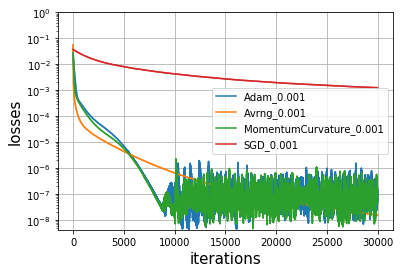

In [522]:
# plot best learning rate for (method, batch_size, kappa)
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import numpy as np
import os
from lib.utils import smooth

def plot_best(kappa, batch_size, 
              plot_key='losses', ylim=None, 
              criteria=lambda x: True, 
              index_dir='synthetic_data_results/LSR',
              smooth_window=1):
    
    # build index if not exist
    if not os.path.exists('{}/index.ind'.format(index_dir)):
        ind = {}
        # build an index based on kappa and batch_size
        for fn in tqdm.tqdm(glob.glob('{}/*.pkl'.format(index_dir))):
            data = joblib.load(fn)
            if data['kappa'] not in ind:
                ind[data['kappa']] = {}
            if data['batch_size'] not in ind[data['kappa']]:
                ind[data['kappa']][data['batch_size']] = []
            ind[data['kappa']][data['batch_size']].append(fn)
        joblib.dump(ind, '{}/index.ind'.format(index_dir))
        
    ind = joblib.load('{}/index.ind'.format(index_dir))

    res = {}
    for fn in ind[kappa][batch_size]:
        data = joblib.load('{}/{}'.format(index_dir, fn.split('/')[-1]))
        name = data['opt'].split('.')[-1]
        if not criteria(data):
            continue
        if not res.get(name): 
            res[name] = {}
        if not res[name].get(data['lr']):
            res[name][data['lr']] = []
        res[name][data['lr']].append(smooth(data[plot_key], smooth_window))
    print('done processing data')
    
    # sort to get best learning rate
    for name, v in res.items():
        lr, _ = sorted([(lr, np.mean(vals)) for lr, vals in v.items()], key=lambda k: k[1])[0]
        p = plt.semilogy(np.percentile(v[lr], 50, 0), label='{}_{}'.format(name, lr))
        plt.semilogy(np.percentile(v[lr], 25, 0), alpha=0.5, c=p[-1].get_color())
        plt.semilogy(np.percentile(v[lr], 75, 0), alpha=0.5, c=p[-1].get_color())

    plt.ylabel('{}'.format(plot_key), fontsize=15)
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel('iterations', fontsize=15)
    plt.grid()
    plt.show()
    
plot_best(10**4, 50, criteria=lambda data: data['lr'] == 0.001, 
          index_dir='synthetic_data_results/LSR', ylim=[0,1])


done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


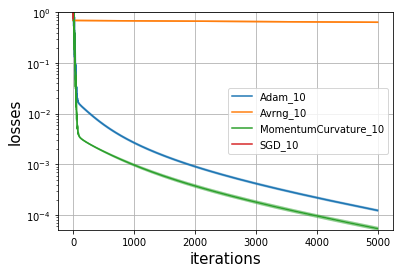

In [524]:
plot_best(1, 300, criteria=lambda data: data['lr'] == 10, 
          index_dir='synthetic_data_results/LogisticRegression/', ylim=[0,1])

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


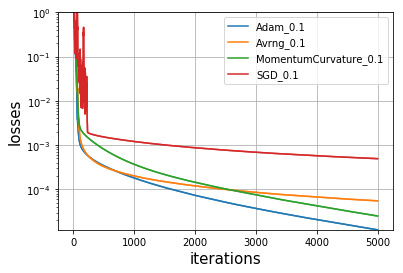

done processing data


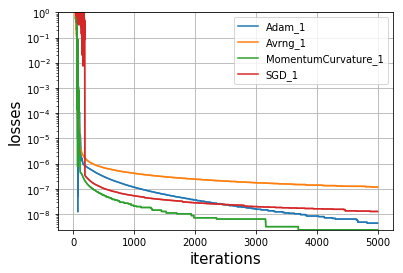

In [528]:
plot_best(10**8, 300, criteria=lambda data: data['lr'] == 0.1, 
          index_dir='synthetic_data_results/LogisticRegression/', ylim=[0,1])

plot_best(10**8, 300, criteria=lambda data: data['lr'] == 1, 
          index_dir='synthetic_data_results/LogisticRegression/', ylim=[0,1])

# TODO: remove index when all done

100%|██████████| 289/289 [00:55<00:00,  5.25it/s]


done processing data


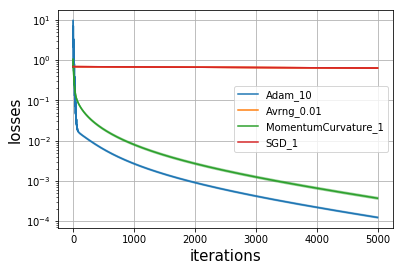

done processing data


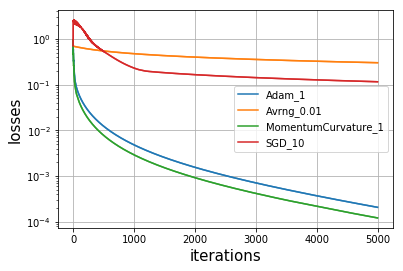

done processing data


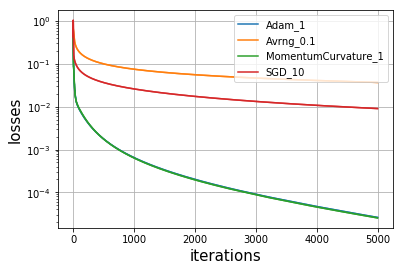

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


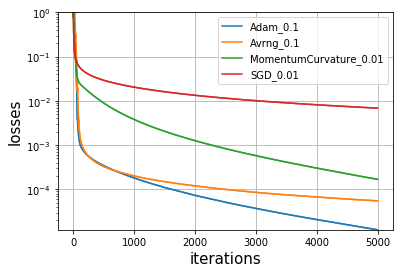

In [511]:
plot_best(1, 300, index_dir='synthetic_data_results/LogisticRegression/')
plot_best(10**2, 300, index_dir='synthetic_data_results/LogisticRegression/')
plot_best(10**4, 300, index_dir='synthetic_data_results/LogisticRegression/')
plot_best(10**8, 300, ylim=[0,1], index_dir='synthetic_data_results/LogisticRegression/')

done processing data


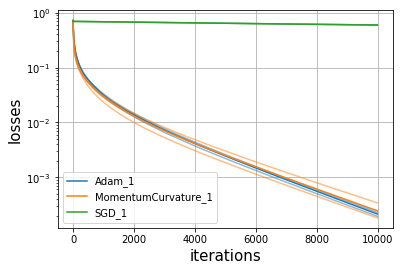

done processing data


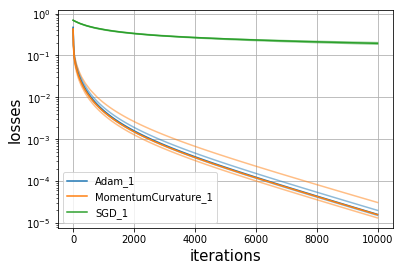

done processing data


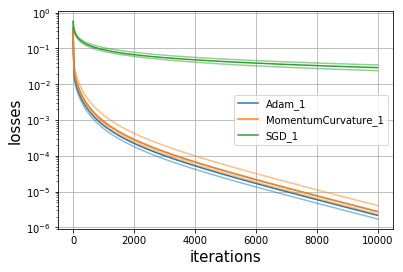

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


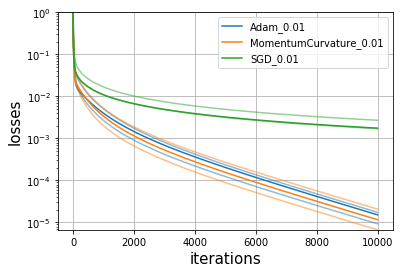

In [185]:
plot_best(1, 150, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**2, 150, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**4, 150, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**8, 150, ylim=[0,1], index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)

done processing data


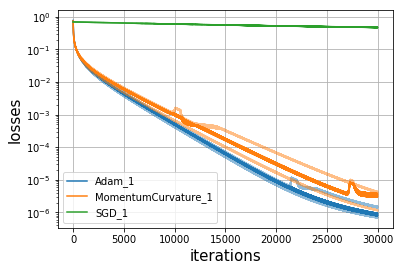

done processing data


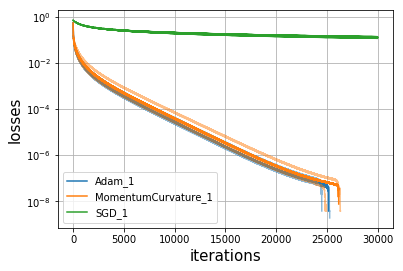

done processing data


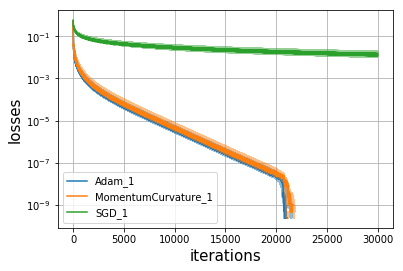

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


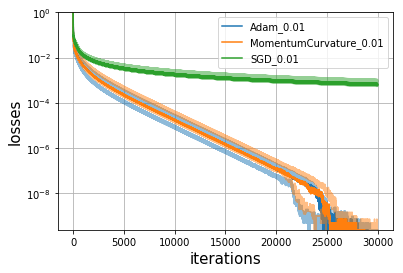

In [187]:
plot_best(1, 50, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**2, 50, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**4, 50, index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)
plot_best(10**8, 50, ylim=[0,1], index_dir='synthetic_data_results2/LogisticRegression/', smooth_window=10)

# LSR results

100%|██████████| 304/304 [00:55<00:00,  5.50it/s]


done processing data


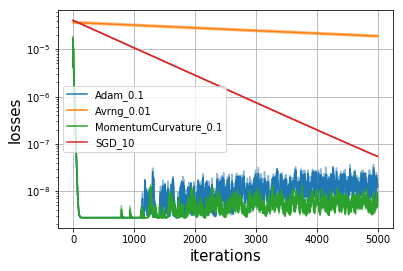

done processing data


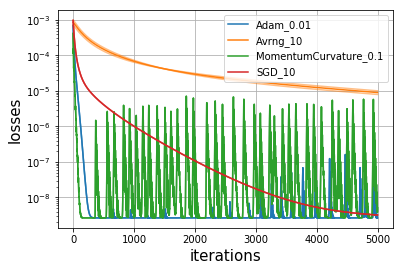

done processing data


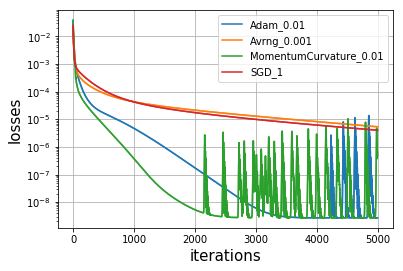

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


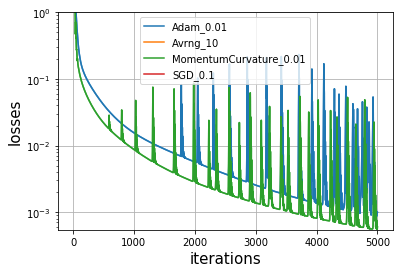

In [513]:
plot_best(1, 300)
plot_best(10**2, 300)
plot_best(10**4, 300)
plot_best(10**8, 300, ylim=[0,1])

done processing data


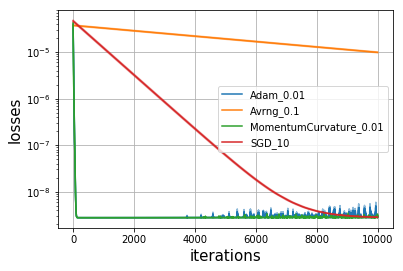

done processing data


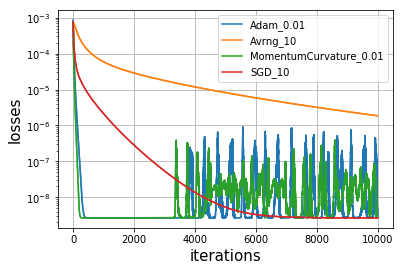

done processing data


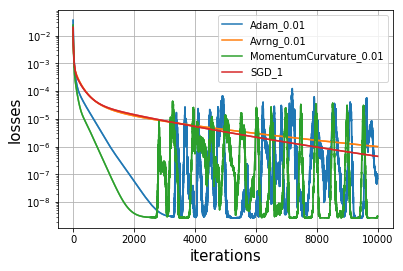

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


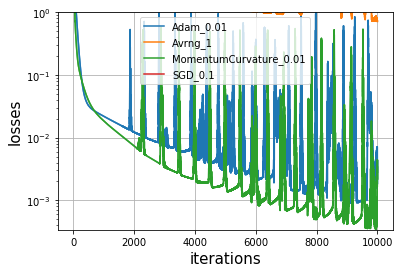

In [514]:
plot_best(1, 150)
plot_best(10**2, 150)
plot_best(10**4, 150)
plot_best(10**8, 150, ylim=[0,1])

done processing data


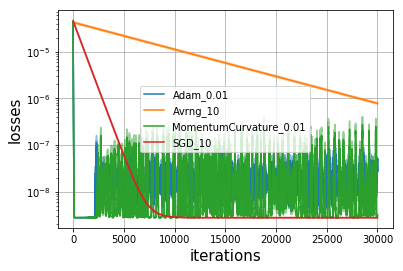

done processing data


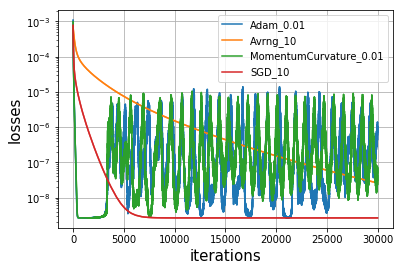

done processing data


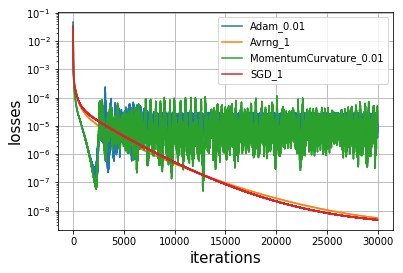

done processing data


/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


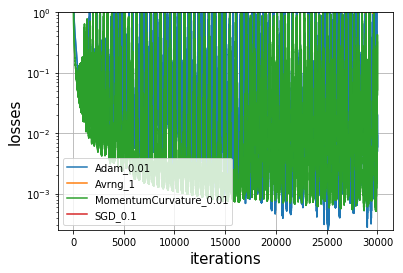

In [515]:
plot_best(1, 50)
plot_best(10**2, 50)
plot_best(10**4, 50)
plot_best(10**8, 50, ylim=[0,1])

# working setting on subset of CIFAR10

Diff: 97.95% (0.00) 1 runs
SGD: 96.87% (0.00) 1 runs
Adam: 97.38% (0.00) 1 runs
MomentumCurvature: 97.74% (0.00) 1 runs


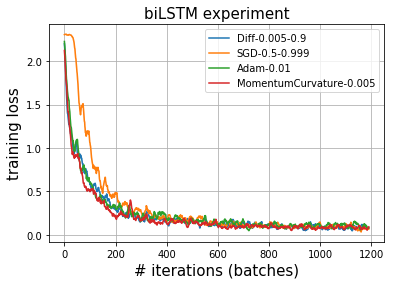

In [10]:
import glob
import matplotlib.pyplot as plt
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

def plot_best(pattern, smooth_window=1, title=None, ylim=None, xlim=None, methods=None, method2label=None):
    methods_settings = {}
    accs = {}
    for fn in sorted(glob.glob(pattern)):
        method_setting = fn.split('/')[-1].split('^')[0].split('-')
        method, setting = method_setting[0], '-'.join(method_setting[1:])
        if methods is not None and method not in methods:
            continue
        
        if method not in methods_settings:
            methods_settings[method] = {}
            accs[method] = {}
        if setting not in methods_settings[method]:
            methods_settings[method][setting] = []
            accs[method][setting] = []
        
        methods_settings[method][setting].append(smooth(joblib.load(fn), smooth_window))
        accs[method][setting].append(float(fn.split('/')[-1].split('^')[1]))
        
    if len(methods_settings.keys()) > 1: # plot the best one, smallest area under the curve
        for method, setting_dict in methods_settings.items():
            setting_areas = []
            for setting, v in setting_dict.items():
                # find the smallest area
                area = np.sum(np.mean(v))
                setting_areas.append((setting, area))
            setting = sorted(setting_areas, key=lambda x: x[1])[0][0]
            v = setting_dict[setting]
            print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                np.std(accs[method][setting]),
                                                len(accs[method][setting])))
            
            if method2label is None:
                label = method + '-' + setting
            else:
                label = method2label.get(method, method)
            #p = plt.plot(sum(v) / len(v), label=method + '-' + setting)#, c=colors[i])            
            p = plt.plot(np.percentile(v, 50, 0), label=label)
            plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
            plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
            #plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
            #plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            #plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
                        
    else: # plot all
        for method, setting_dict in methods_settings.items():
            for setting, v in setting_dict.items():                
                print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                            np.std(accs[method][setting]), 
                                                            len(accs[method][setting])))
                
                if method2label is None:
                    label = method + '-' + setting
                else:
                    label = method2label.get(method,method) + '-' + setting
                
                p = plt.plot(np.percentile(v, 50, 0), label=label)
                plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
                plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
                #plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
                #plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
                #plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
                
        
    plt.legend()
    if title:
        plt.title(title, fontsize=15)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.ylabel('training loss', fontsize=15)
    plt.xlabel('# iterations (batches)', fontsize=15)
    plt.grid()
    plt.show()     

plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/bidirectional_recurrent_neural_network/train_loss/*train_losses', 
          title='biLSTM experiment',
          smooth_window=10)

SGD: 26.80% (2.90) 35 runs
Adam: 29.28% (2.47) 36 runs
MomentumCurvature: 29.48% (2.43) 36 runs


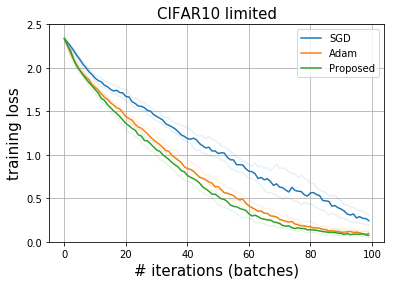

In [14]:
plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/CIFAR10_limited/train_loss/*train_losses', 
          title='CIFAR10 limited',
          smooth_window=1, ylim=[0,2.5], 
          methods=['SGD', 'MomentumCurvature', 'Adam'],
          method2label={'MomentumCurvature': 'Proposed'})
#plt.savefig('CIFAR-10', )

Sign: 92.00% (0.00) 5 runs
Avrng: 92.00% (0.00) 5 runs
MomentumCurvature: 92.00% (0.00) 5 runs
Diff: 92.00% (0.00) 5 runs
Adam: 92.00% (0.00) 5 runs
AMSGrad: 92.00% (0.00) 5 runs


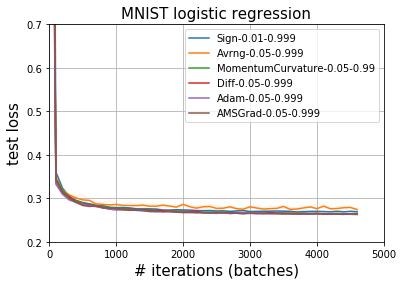

In [772]:
def plot_best_full(pattern, title=None, ylabel=None, ylim=None, xlim=None):
    methods_settings = {}
    accs = {}
    for fn in sorted(glob.glob(pattern)):
        method_setting = fn.split('/')[-1].split('^')[0].split('-')
        method, setting = method_setting[0], '-'.join(method_setting[1:])
        
        if method not in methods_settings:
            methods_settings[method] = {}
            accs[method] = {}
        if setting not in methods_settings[method]:
            methods_settings[method][setting] = []
            accs[method][setting] = []
        
        methods_settings[method][setting].append(joblib.load(fn))
        accs[method][setting].append(float(fn.split('/')[-1].split('^')[1]))
        
    if len(methods_settings.keys()) > 1: # plot the best one, smallest area under the curve
        for method, setting_dict in methods_settings.items():
            setting_areas = []
            for setting, v in setting_dict.items():
                # find the smallest area
                v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
                area = np.sum(np.mean(v))
                setting_areas.append((setting, area))
            setting = sorted(setting_areas, key=lambda x: x[1])[0][0]
            v = setting_dict[setting]
            t = list(map(lambda t_val_line: [t for t, val in t_val_line], v))
            v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
            print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                        np.std(accs[method][setting]),
                                                        len(accs[method][setting])))
            p = plt.plot(t[0], np.percentile(v, 50, 0), label=method + '-' + setting)#, c=colors[i])
            plt.plot(t[0], np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
            plt.plot(t[0], np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
            #plt.semilogy(t[0], np.percentile(v, 50, 0), label=k, c=colors[i])
            #plt.semilogy(t[0], np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            #plt.semilogy(t[0], np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
                        
    else: # plot all
        for method, setting_dict in methods_settings.items():
            for setting, v in setting_dict.items():                
                print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                            np.std(accs[method][setting]), 
                                                            len(accs[method][setting])))
                
                t = list(map(lambda t_val_line: [t for t, val in t_val_line], v))
                v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
                
                p = plt.plot(t[0], np.percentile(v, 50, 0), label=method + '-' + setting)#, c=colors[i])
                plt.plot(t[0], np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
                plt.plot(t[0], np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
                
                #plt.semilogy(t[0], np.percentile(v, 50, 0), label=k, c=colors[i])
                #plt.semilogy(t[0], np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
                #plt.semilogy(t[0], np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
        
    plt.legend()
    if title:
        plt.title(title, fontsize=15)
    plt.ylim(ylim)
    plt.xlim(xlim)
    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    plt.xlabel('# iterations (batches)', fontsize=15)
    plt.grid()
    plt.show()     

plot_best_full('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/logistic_regression/full_loss/*test_losses',  # full_loss
               title='MNIST logistic regression', 
               ylim=[0.2, 0.7], xlim=[-2,5000], ylabel='test loss')

# reproduce marginal value paper

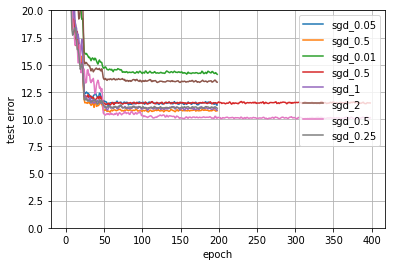

In [814]:
import json
import glob
from lib.utils import smooth

def cifar10_pattern(logs, test=False, ylim=None, acc=True, smooth_window=1, logscale=False):
    if not ylim and acc:
        ylim = [0,20]
    colors = ['r', 'g', 'b', 'k', 'orange', 'pink', 'yellow', 'violet']
    for i, pattern in enumerate(logs):
        for log in glob.glob(pattern):
            name = '_'.join(log.split('/')[-2].split('_')[:2])
            tr_errs = []
            te_errs = []
            with open(log) as f:
                for l in f:
                    d = json.loads(l[len('json_status:'):])
                    if acc:
                        tr_errs.append(100-d['train_acc'])
                        te_errs.append(100-d['test_acc'])
                    else:
                        tr_errs.append(d['train_loss'])
                        tr_errs.append(d['test_loss']) # note no test_loss

                if test:
                    errs = smooth(te_errs, smooth_window)
                else:
                    errs = smooth(tr_errs, smooth_window)
                if len(logs) > 1:
                    if not logscale:
                        plt.plot(errs, label=name, color=colors[i])
                    else:
                        plt.semilogy(errs, label=name, color=colors[i])
                else:
                    if not logscale:
                        plt.plot(errs, label=name)
                    else:
                        plt.semilogy(errs, label=name)
                    
    plt.legend()
    plt.grid()
    #plt.axhline(20, linestyle='--')
    #plt.axvline(10, linestyle='--')
    plt.ylim(ylim)
    plt.ylabel('{} error'.format('test' if test else 'train'))
    plt.xlabel('epoch')
    plt.show()    
        
logs = [
    '../wide-residual-networks/pytorch/logs_25/sgd_*_*/log.txt', # best range [0.25, 0.5*, 1]
    #'../wide-residual-networks/pytorch/logs_25/diff_*_*/log.txt', # best range [0.001, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/adam_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/mc_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/avrng_*_*/log.txt', # best range: [0.01-,0.1*,0.5,1,2]
    #'../wide-residual-networks/pytorch/logs/sign_*_*/log.txt', # need to try smaller values
    #'../wide-residual-networks/pytorch/logs/adamvr_*_*/log.txt',
]
cifar10_pattern(logs, test=True, acc=True, logscale=False, smooth_window=2)

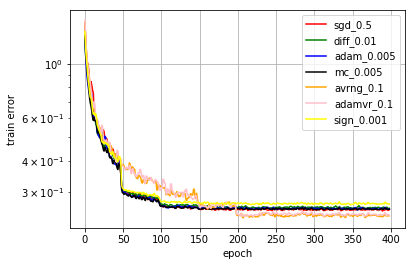

In [826]:
logs = [
    '../wide-residual-networks/pytorch/logs_25/sgd_0.5_13572/log.txt', # best range [0.25, 0.5*, 1]
    '../wide-residual-networks/pytorch/logs_25/diff_0.01_*/log.txt', # best range [0.001, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs_25/adam_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs_25/mc_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs_25/avrng_0.1_*/log.txt', # best range: [0.01-,0.1*,0.5,1,2]
    '../wide-residual-networks/pytorch/logs/adamvr_0.1_*/log.txt',
    '../wide-residual-networks/pytorch/logs/sign_0.001_*/log.txt', 
]
cifar10_pattern(logs, test=False, acc=False, logscale=True, smooth_window=2)

# training decay at epoch 60, 120, 160

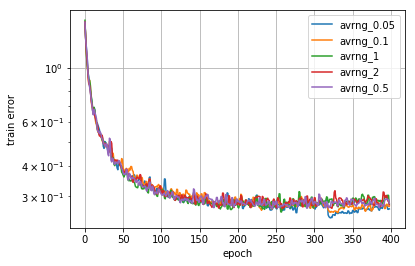

In [825]:
logs = [
    #'../wide-residual-networks/pytorch/logs/sgd_0.5_*/log.txt', # best range [0.25, 0.5*, 1]
    #'../wide-residual-networks/pytorch/logs/vanillaSGD_*_*/log.txt',
    #'../wide-residual-networks/pytorch/logs/adam_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs/mc_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs/avrng_*_*/log.txt', # best range: [0.05,0.1*,0.5,1,2]
]
cifar10_pattern(logs, test=False, acc=False, logscale=True, smooth_window=2)

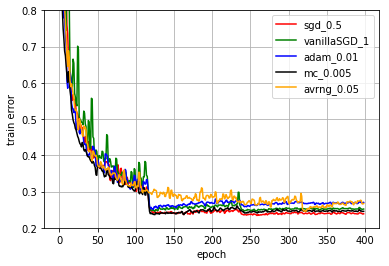

In [873]:
logs = [
    '../wide-residual-networks/pytorch/logs/sgd_0.5_*/log.txt', # best range [0.25, 0.5*, 1]
    '../wide-residual-networks/pytorch/logs/vanillaSGD_1_*/log.txt',
    '../wide-residual-networks/pytorch/logs/adam_0.01_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs/mc_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs/avrng_0.05_*/log.txt', # need to try smaller values
]
cifar10_pattern(logs, test=False, ylim=[0.2,0.8], acc=False, logscale=False, smooth_window=2)